In [13]:
include("utils/preprocessing.jl")
include("utils/model_evaluation.jl")
include("utils/data_loader.jl")
include("utils/visualization.jl")
include("utils/ml1_utils.jl")

evaluateAndPrintMetricsRanking (generic function with 1 method)

In [9]:
# import Pkg;
# Pkg.add("Random")
# Pkg.add("MLBase")
# Pkg.add("JLD")
# Pkg.add("ScikitLearn")

using Random
Random.seed!(123)

using ScikitLearn
using JLD
@sk_import decomposition: PCA

PyObject <class 'sklearn.decomposition._pca.PCA'>

## DESCRIPTION OF APPROACH ##

##### LOAD THE DATA #####

In [14]:
data = DataLoader.load_data("dataset\\star_classification.csv");

##### (OPTIONAL) REDUCE THE DATASET #####

In [4]:
Random.seed!(123)

""" 
The method used to reduce the number of rows in the dataset is called
stratifed sampling. This method ensures that the reduced dataset has
the same proportion of classes as the original dataset.
"""

function reduce_data(dataset::Matrix, percentage_to_keep::Float64)
    # Extract data and targets from the dataset
    data = dataset[:, 1:end-1]
    targets = dataset[:, 14] 
    
    unique_classes = unique(targets)
    reduced_data = Matrix{Float64}(undef, 0, size(data, 2))
    reduced_targets = Vector{Float64}()

    for class in unique_classes
        # Get the data and targets for this class
        class_data = data[targets .== class, :]
        class_targets = targets[targets .== class]

        # Calculate the number of rows to keep
        num_rows_to_keep = Int(ceil(size(class_data, 1) * percentage_to_keep))

        # Randomly select the subset of rows
        indices = randperm(size(class_data, 1))[1:num_rows_to_keep]
        subset_class_data = class_data[indices, :]
        subset_class_targets = class_targets[indices]

        # Append the reduced data and targets for this class to the overall reduced data and targets
        reduced_data = vcat(reduced_data, subset_class_data)
        reduced_targets = vcat(reduced_targets, subset_class_targets)
    end

    # Combine reduced data and targets
    reduced_dataset = hcat(reduced_data, reduced_targets)

    return reduced_dataset
end


reduced_data = reduce_data(data, 0.10)

10003×18 Matrix{Any}:
                    "obj_ID"  …       "plate"       "MJD"  "class"
 1237663917871596800              3656         55241       "GALAXY"
 1237654381974127616              6395         56354       "GALAXY"
 1237660763222443008              4481         55630       "GALAXY"
 1237660962397749504              1267         52932       "GALAXY"
 1237679322864222464          …   9315         57713       "GALAXY"
 1237667781742232320              5305         55984       "GALAXY"
 1237657589784772864              1016         52759       "GALAXY"
 1237665127995867904             10452         58138       "GALAXY"
 1237648704587432448              4043         55630       "GALAXY"
 1237664877805962240          …  10451         58141       "GALAXY"
 1237680504510678016              7136         56570       "GALAXY"
 1237664817671241728              2034         53466       "GALAXY"
                   ⋮          ⋱      ⋮                     
 1237663918416134656              5

##### PREPROCESSING THE DATASET #####

In [31]:
using ScikitLearn

@sk_import decomposition:PCA

PyObject <class 'sklearn.decomposition._pca.PCA'>

In [15]:
# preprocess_data(dataset, holdOut ratio, normalization method, balancing_dataset, features)
train_inputs, train_targets, test_inputs, test_targets = Preprocessing.preprocess_data(data, 0.1, 0.2, "zero_mean", true, [4,5,6,7,8,15])

"""    This function does the following:
        - Balance the data using the undersampling method if chosen to do so
        - Parse the data: chosing the correct columns for inputs and targets (Shouldn't this be done before balancing??)
        - Splits the data into training and testing using holdOut method
        - Normalize the inputs
"""

# Print first input and target
println("First input: ", train_inputs[1, :])
println("First target: ", train_targets[1, :])

First input: Float32[-0.18184435, -0.1063038, 0.32182, 0.5550667, 0.76979786, -0.76223695]
First target: Any["STAR"]


In [16]:
""" 
This would be cooler to have in the preprocess_data function
but I've tried and failed miserably
"""

@sk_import decomposition:PCA

pca = PCA(0.95)
fit!(pca, train_inputs)

#Once it is ajusted it can be used to transform the data
train_inputs = pca.transform(train_inputs)
test_inputs = pca.transform(test_inputs)

print("Train Patterns ", size(train_inputs))
print("Train Patterns ", size(test_inputs))

Train Patterns (4553, 3)Train Patterns (1138, 3)

## Testing hyperparameters for each model ##

In [7]:
@sk_import neural_network: MLPClassifier;
@sk_import svm: SVC;
@sk_import tree: DecisionTreeClassifier;
@sk_import neighbors: KNeighborsClassifier;
@sk_import ensemble: RandomForestClassifier;
@sk_import ensemble: StackingClassifier;
@sk_import metrics: accuracy_score;

In [8]:
"""
Setting indices for the k-fold cross-validation
    we are about to do with the different models
"""
N=size(train_inputs,1)
k = 5 # number of folds
kFoldIndices = crossvalidation(N, k);

In [9]:
"""
Setting indices for the k-fold cross-validation
    we are about to do with the different models
"""
N=size(pca_train,1)
k = 3 # number of folds
kFoldIndices = crossvalidation(N, k);

##### DECISION TREE #####

In [10]:
# Define an array of hyperparameter dictionaries for the Decision Tree model
dtree_hyperparameters_array = [
    Dict("max_depth" => 3),
    Dict("max_depth" => 5),
    Dict("max_depth" => 10),
    Dict("max_depth" => 20),
    Dict("max_depth" => 50),
    Dict("max_depth" => 100) # Deeper trees can capture more detail but risk overfitting
]

# Call the function to evaluate the model using different sets of hyperparameters and print the ranking of metrics.
evaluateAndPrintMetricsRanking(:DecisionTree,dtree_hyperparameters_array, pca_train, train_targets, kFoldIndices)

Training with set of hyperparameters 1
Training with set of hyperparameters 2
Training with set of hyperparameters 3
Training with set of hyperparameters 4
Training with set of hyperparameters 5
Training with set of hyperparameters 6

----- acc -----
Set of hyperparameters 4 -> mean: 0.887 Std. Dev.: 0.014
Set of hyperparameters 5 -> mean: 0.887 Std. Dev.: 0.014
Set of hyperparameters 6 -> mean: 0.887 Std. Dev.: 0.014
Set of hyperparameters 3 -> mean: 0.884 Std. Dev.: 0.014
Set of hyperparameters 2 -> mean: 0.832 Std. Dev.: 0.017
Set of hyperparameters 1 -> mean: 0.785 Std. Dev.: 0.014

----- sensitivity -----
Set of hyperparameters 4 -> mean: 0.887 Std. Dev.: 0.014
Set of hyperparameters 5 -> mean: 0.887 Std. Dev.: 0.014
Set of hyperparameters 6 -> mean: 0.887 Std. Dev.: 0.014
Set of hyperparameters 3 -> mean: 0.884 Std. Dev.: 0.014
Set of hyperparameters 2 -> mean: 0.832 Std. Dev.: 0.017
Set of hyperparameters 1 -> mean: 0.785 Std. Dev.: 0.014

----- specificity -----
Set of hyperpar

##### kNN #####

In [11]:
# Define an array of hyperparameter dictionaries for the kNN model
knn_hyperparameters_array = [
    Dict("n_neighbors" => 5),
    Dict("n_neighbors" => 10),
    Dict("n_neighbors" => 15),
    Dict("n_neighbors" => 20),
    Dict("n_neighbors" => 50),
    Dict("n_neighbors" => 100) # Large neighborhoods, smooths out predictions
]

# Call the function to evaluate the model using different sets of hyperparameters and print the ranking of metrics.
evaluateAndPrintMetricsRanking(:kNN,knn_hyperparameters_array, train_inputs, train_targets, kFoldIndices)

Training with set of hyperparameters 1
Training with set of hyperparameters 2
Training with set of hyperparameters 3
Training with set of hyperparameters 4
Training with set of hyperparameters 5
Training with set of hyperparameters 6

----- acc -----
Set of hyperparameters 1 -> mean: 0.929 Std. Dev.: 0.004
Set of hyperparameters 2 -> mean: 0.918 Std. Dev.: 0.005
Set of hyperparameters 3 -> mean: 0.907 Std. Dev.: 0.003
Set of hyperparameters 4 -> mean: 0.898 Std. Dev.: 0.01
Set of hyperparameters 5 -> mean: 0.867 Std. Dev.: 0.015
Set of hyperparameters 6 -> mean: 0.835 Std. Dev.: 0.02

----- sensitivity -----
Set of hyperparameters 1 -> mean: 0.929 Std. Dev.: 0.004
Set of hyperparameters 2 -> mean: 0.918 Std. Dev.: 0.005
Set of hyperparameters 3 -> mean: 0.907 Std. Dev.: 0.003
Set of hyperparameters 4 -> mean: 0.898 Std. Dev.: 0.01
Set of hyperparameters 5 -> mean: 0.867 Std. Dev.: 0.015
Set of hyperparameters 6 -> mean: 0.835 Std. Dev.: 0.02

----- specificity -----
Set of hyperparamet

##### SVM #####

In [12]:
svm_hyperparameters_array = [
    # Uses 'rbf' kernel, medium complexity with C=1.0, default polynomial degree, 'scale' for gamma 
    Dict("kernel" => "rbf", "degree" => 3, "C" => 1.0, "gamma" => "scale"),
    
    # Same 'rbf' kernel, increased penalty (C=10.0) for larger-margin separation, 'auto' gamma adjusts based on features
    Dict("kernel" => "rbf", "degree" => 3, "C" => 10.0, "gamma" => "auto"),
    
    # Same 'rbf' kernel, lower penalty (C=0.1) for a softer-margin, 'scale' gamma is default scaling
    Dict("kernel" => "rbf", "degree" => 3, "C" => 0.1, "gamma" => "scale"),

    # 'linear' kernel, suitable for less complex data
    Dict("kernel" => "linear", "degree" => 5,  "C" => 0.1, "gamma" => "auto"),
    
    # 'linear' kernel, not affected by 'degree' or 'gamma', with C=1.0 indicating a balance between margin and misclassification
    Dict("kernel" => "linear", "degree" => 3, "C" => 1.0, "gamma" => "auto"),

    # 'linear' kernel with a higher penalty, stricter margin
    Dict("kernel" => "linear", "degree" => 7, "C" => 10.0, "gamma" => "scale"),
    
    # 'poly' kernel, polynomial degree is set twice by mistake, should only be 'degree' => 3, 'scale' gamma defaults to feature scale
    Dict("kernel" => "poly", "degree" => 3, "C" => 1.0, "gamma" => "scale"),
    
    # 'poly' kernel, increased polynomial degree (5) for higher model complexity, 'auto' gamma may overfit with high dimension
    Dict("kernel" => "poly", "degree" => 5, "C" => 1.0, "gamma" => "auto")
]


# Call the function to evaluate the model using different sets of hyperparameters and print the ranking of metrics.
evaluateAndPrintMetricsRanking(:SVM, svm_hyperparameters_array, train_inputs, train_targets, kFoldIndices)

Training with set of hyperparameters 1
Training with set of hyperparameters 2
Training with set of hyperparameters 3
Training with set of hyperparameters 4
Training with set of hyperparameters 5
Training with set of hyperparameters 6
Training with set of hyperparameters 7
Training with set of hyperparameters 8

----- acc -----
Set of hyperparameters 2 -> mean: 0.953 Std. Dev.: 0.004
Set of hyperparameters 6 -> mean: 0.948 Std. Dev.: 0.008
Set of hyperparameters 1 -> mean: 0.937 Std. Dev.: 0.003
Set of hyperparameters 5 -> mean: 0.936 Std. Dev.: 0.006
Set of hyperparameters 3 -> mean: 0.884 Std. Dev.: 0.008
Set of hyperparameters 4 -> mean: 0.867 Std. Dev.: 0.005
Set of hyperparameters 7 -> mean: 0.862 Std. Dev.: 0.009
Set of hyperparameters 8 -> mean: 0.765 Std. Dev.: 0.037

----- sensitivity -----
Set of hyperparameters 2 -> mean: 0.953 Std. Dev.: 0.004
Set of hyperparameters 6 -> mean: 0.948 Std. Dev.: 0.008
Set of hyperparameters 1 -> mean: 0.937 Std. Dev.: 0.003
Set of hyperparamet

##### ANN #####

In [13]:
# Define an array of hyperparameter dictionaries for the ANN model
ann_hyperparameters_array = [
    # Two-layer architecture, moderate neurons
    Dict("architecture" => [50, 30], "activation" => "relu", "learning_rate" => 0.01, "validation_ratio" => 0.1, "n_iter_no_change" => 80, "max_iter" => 1000, "repetitionsTraining" => 10),

    # One-layer architecture, fewer neurons
    Dict("architecture" => [30], "activation" => "relu", "learning_rate" => 0.01, "validation_ratio" => 0.1, "n_iter_no_change" => 80, "max_iter" => 1000, "repetitionsTraining" => 10),

    # Two-layer, different activation function
    Dict("architecture" => [50, 30], "activation" => "tanh", "learning_rate" => 0.01, "validation_ratio" => 0.1, "n_iter_no_change" => 80, "max_iter" => 1000, "repetitionsTraining" => 10),

    # One-layer, lower learning rate
    Dict("architecture" => [30], "activation" => "relu", "learning_rate" => 0.001, "validation_ratio" => 0.1, "n_iter_no_change" => 80, "max_iter" => 2000, "repetitionsTraining" => 10),

    # Two-layer, higher learning rate
    Dict("architecture" => [50, 30], "activation" => "relu", "learning_rate" => 0.05, "validation_ratio" => 0.1, "n_iter_no_change" => 80, "max_iter" => 1000, "repetitionsTraining" => 10),

    # One-layer, logistic activation
    Dict("architecture" => [30], "activation" => "logistic", "learning_rate" => 0.01, "validation_ratio" => 0.1, "n_iter_no_change" => 80, "max_iter" => 1000, "repetitionsTraining" => 10),

    # Two-layer, more neurons, different activation
    Dict("architecture" => [70, 40], "activation" => "tanh", "learning_rate" => 0.01, "validation_ratio" => 0.1, "n_iter_no_change" => 80, "max_iter" => 1000, "repetitionsTraining" => 10),

    # One-layer, more neurons
    Dict("architecture" => [50], "activation" => "relu", "learning_rate" => 0.01, "validation_ratio" => 0.1, "n_iter_no_change" => 80, "max_iter" => 1000, "repetitionsTraining" => 10)
]

# Call the function to evaluate the model using different sets of hyperparameters and print the ranking of metrics.
evaluateAndPrintMetricsRanking(:ANN, ann_hyperparameters_array, pca_train, train_targets, kFoldIndices)

Training with set of hyperparameters 1
Training with set of hyperparameters 2
Training with set of hyperparameters 3
Training with set of hyperparameters 4


##### TRAINING MODELS WITH WHOLE DATASET #####

In [ ]:
""" DECISION TREE MODEL """

dt_model = DecisionTreeClassifier(max_depth=10)
println("After calling the model")

# Fit the model on the training data
ScikitLearn.fit!(dt_model, train_inputs, train_targets)

# Predict the targets for the test data
predicted_targets = ScikitLearn.predict(dt_model, test_inputs)

# Calculate and print the accuracy
DT_acc, DT_error_rate, DT_sensitivity, DT_specificity, DT_PPV, DT_NPV, DT_F_score, DT_confusion = confusionMatrix(predicted_targets, test_targets)

println("Decision Tree model accuracy: $(DT_acc * 100) %")
println("Decision Tree model sensitivity: $(DT_sensitivity * 100) %")
println("Decision Tree model specificity: $(DT_specificity * 100) %")
println("Decision Tree model PPV: $(DT_PPV * 100) %")
println("Decision Tree model NPV: $(DT_NPV * 100) %")
println("Decision Tree model sensitivity: $(DT_F_score * 100) %")

# Save the model
#JLD.save("dt_model.jld", "model", dt_model)

After calling the model
Decision Tree model accuracy: 93.8062815725895 %
Decision Tree model sensitivity: 93.8062815725895 %
Decision Tree model specificity: 96.90074951345646 %
Decision Tree model PPV: 93.8425221690431 %
Decision Tree model NPV: 96.91950354493346 %
Decision Tree model sensitivity: 93.78643945984993 %


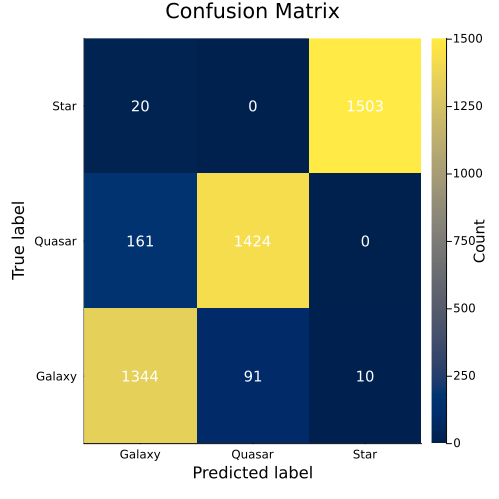

In [ ]:
""" Printing the confusion matrix """
p0 = Visualization.plot_confusion_heatmap(DT_confusion)
display(p0)

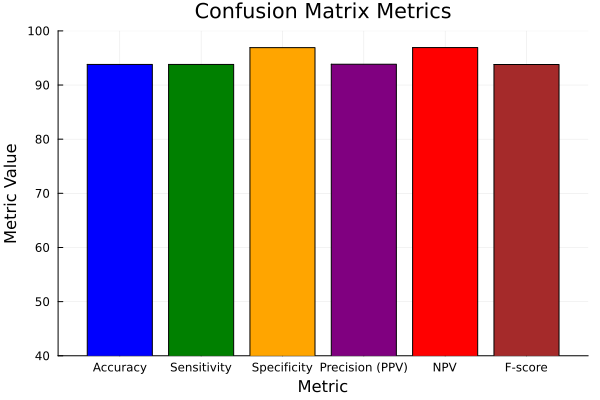

In [ ]:
Visualization.plot_confusion_metrics(DT_acc, DT_sensitivity, DT_specificity, DT_PPV, DT_NPV, DT_F_score)

In [ ]:
""" KNN MODEL """
knn_model = KNeighborsClassifier(n_neighbors=5)

# Fit the model on the training data
ScikitLearn.fit!(knn_model, train_inputs, train_targets)

# Predict the targets for the test data
predicted_targets = ScikitLearn.predict(knn_model, test_inputs)

# Calculate and print the accuracy
KNN_acc, KNN_error_rate, KNN_sensitivity, KNN_specificity, KNN_PPV, KNN_NPV, KNN_F_score, KNN_confusion = confusionMatrix(predicted_targets, test_targets)

println("KNN model accuracy: $(KNN_acc * 100) %")
println("KNN model sensitivity: $(KNN_sensitivity * 100) %")
println("KNN model specificity: $(KNN_specificity * 100) %")
println("KNN model PPV: $(KNN_PPV * 100) %")
println("KNN model NPV: $(KNN_NPV * 100) %")
println("KNN model sensitivity: $(KNN_F_score * 100) %")

# Save the model
#JLD.save("knn_model.jld", "model", knn_model)

KNN model accuracy: 90.22622446738414 %
KNN model sensitivity: 90.22622446738414 %
KNN model specificity: 95.10600761737213 %
KNN model PPV: 90.34029419389016 %
KNN model NPV: 95.1003215870268 %
KNN model sensitivity: 90.25978661181865 %


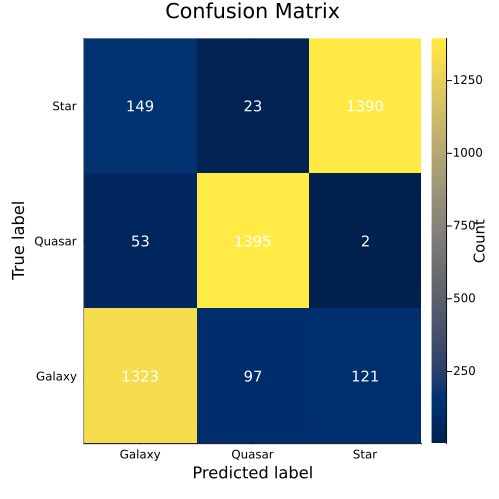

In [ ]:
""" Printing the confusion matrix """
p1 = Visualization.plot_confusion_heatmap(KNN_confusion)
display(p1)

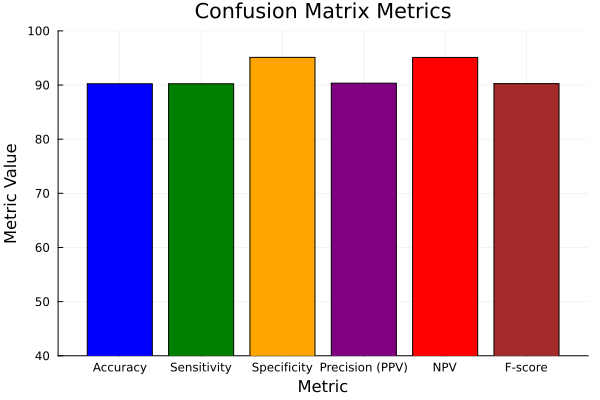

In [ ]:
Visualization.plot_confusion_metrics(KNN_acc, KNN_sensitivity, KNN_specificity, KNN_PPV, KNN_NPV, KNN_F_score)

In [ ]:
""" ANN MODEL """
ann_model = MLPClassifier(hidden_layer_sizes=(50, 30), activation="relu", learning_rate_init=0.01, validation_fraction=0.1, n_iter_no_change=80, max_iter=1000)

# Fit the model on the training data
ScikitLearn.fit!(ann_model, train_inputs, train_targets)

# Predict the targets for the test data
predicted_targets = ScikitLearn.predict(ann_model, test_inputs)

# Calculate and print the accuracy
ANN_acc, ANN_error_rate, ANN_sensitivity, ANN_specificity, ANN_PPV, ANN_NPV, ANN_F_score, ANN_confusion = confusionMatrix(predicted_targets, test_targets)

println("ANN model accuracy: $(ANN_acc * 100) %")
println("ANN model sensitivity: $(ANN_sensitivity * 100) %")
println("ANN model specificity: $(ANN_specificity * 100) %")
println("ANN model PPV: $(ANN_PPV * 100) %")
println("ANN model NPV: $(ANN_NPV * 100) %")
println("ANN model sensitivity: $(ANN_F_score * 100) %")

# Save the model
#JLD.save("ann_model.jld", "model", ann_model)

ANN model accuracy: 94.57500549088513 %
ANN model sensitivity: 94.57500549088512 %
ANN model specificity: 97.28311968015629 %
ANN model PPV: 94.57532934349636 %
ANN model NPV: 97.28420218699631 %
ANN model sensitivity: 94.57221277699762 %


In [ ]:
""" Printing the confusion matrix """
p2 = Visualization.plot_confusion_heatmap(ANN_confusion)
display()

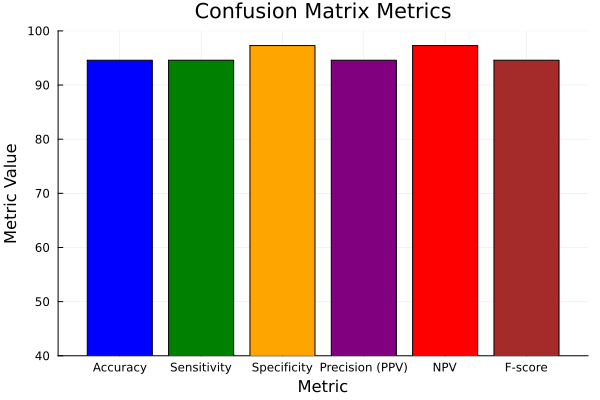

In [ ]:
Visualization.plot_confusion_metrics(ANN_acc, ANN_sensitivity, ANN_specificity, ANN_PPV, ANN_NPV, ANN_F_score)

In [ ]:
""" SVM MODEL """
svm_model = SVC(kernel = "rbf", degree = 3, C = 1.0, gamma = "scale")

# Fit the model on the training data
fit!(svm_model, train_inputs, train_targets)

# Predict the targets for the test data
predicted_targets = predict(svm_model, test_inputs)

# Calculate and print the accuracy
SVM_acc, SVM_error_rate, SVM_sensitivity, SVM_specificity, SVM_PPV, SVM_NPV, SVM_F_score, SVM_confusion = confusionMatrix(predicted_targets, test_targets)

println("SVM model accuracy: $(SVM_acc * 100) %")
println("SVM model sensitivity: $(SVM_sensitivity * 100) %")
println("SVM model specificity: $(SVM_specificity * 100) %")
println("SVM model PPV: $(SVM_PPV * 100) %")
println("SVM model NPV: $(SVM_NPV * 100) %")
println("SVM model sensitivity: $(SVM_F_score * 100) %")

# Save the model
#JLD.save("svm_model.jld", "model", svm_model)

SVM model accuracy: 90.95102130463431 %
SVM model sensitivity: 90.95102130463431 %
SVM model specificity: 95.47412400305535 %
SVM model PPV: 91.09476632858402 %
SVM model NPV: 95.51335013986157 %
SVM model sensitivity: 90.93717820678762 %


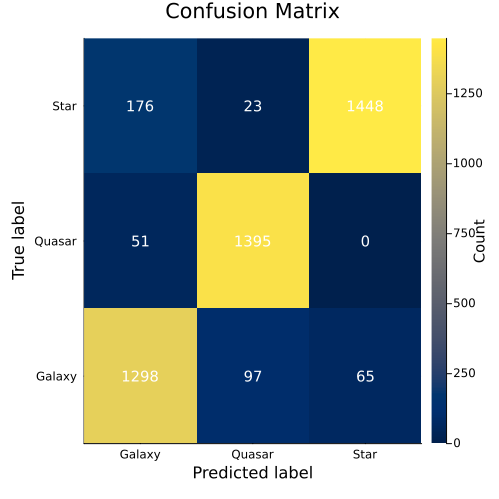

In [ ]:
""" Printing the confusion matrix """
p3 = Visualization.plot_confusion_heatmap(SVM_confusion)
display(p3)

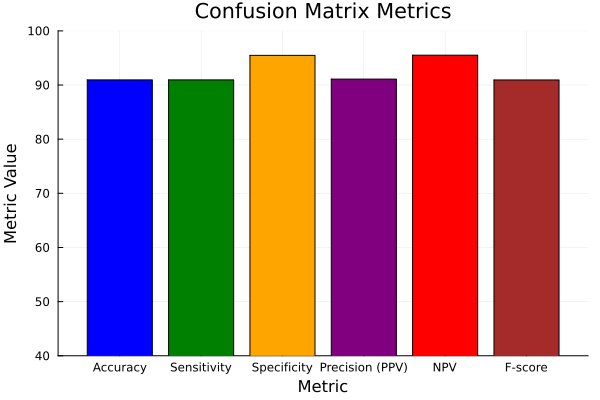

In [ ]:
Visualization.plot_confusion_metrics(SVM_acc, SVM_sensitivity, SVM_specificity, SVM_PPV, SVM_NPV, SVM_F_score)

##### ENSEMBLE MODEL #####

In [ ]:
using ScikitLearn
@sk_import metrics: accuracy_score

# Define the base models with the chosen hyperparameters
dt_model = DecisionTreeClassifier(max_depth=3)
knn_model = KNeighborsClassifier(n_neighbors=5)
ann_model = MLPClassifier(hidden_layer_sizes=(50, 30), activation="tanh", learning_rate_init=0.01, validation_fraction=0.1, n_iter_no_change=80, max_iter=10000) # Increase max_iter from 1000 to ensure convergence
svm_model = SVC(kernel="poly", degree=3, C=1.0, gamma="scale")

# Create a list of tuples (name, model) for the base models
base_models = [
    ("DecisionTree", dt_model),
    ("kNN", knn_model),
    ("ANN", ann_model),
    ("SVM", svm_model)
]

# Choose a final estimator for the stacking ensemble
# Logistic Regression is a common choice for combining predictions
final_estimator = RandomForestClassifier()

# Create the stacking ensemble
ensemble = StackingClassifier(estimators=base_models, final_estimator=final_estimator)

# Train the ensemble model
ScikitLearn.fit!(ensemble, train_inputs, train_targets)

# Evaluate the ensemble model
predicted_targets = ScikitLearn.predict(ensemble, test_inputs)
Ens_acc, Ens_error_rate, Ens_sensitivity, Ens_specificity, Ens_PPV, Ens_NPV, Ens_F_score, Ens_confusion = confusionMatrix(predicted_targets, test_targets)

println("Ensemble model accuracy: $(Ens_acc * 100) %")
println("Ensemble model sensitivity: $(Ens_sensitivity * 100) %")
println("Ensemble model specificity: $(Ens_specificity * 100) %")
println("Ensemble model PPV: $(Ens_PPV * 100) %")
println("Ensemble model NPV: $(Ens_NPV * 100) %")
println("Ensemble model sensitivity: $(Ens_F_score * 100) %")

# Save the model
#JLD.save("ensemble.jld", "model", ensemble)


Ensemble model accuracy: 96.09048978695365 %
Ensemble model sensitivity: 96.09048978695365 %
Ensemble model specificity: 98.0406070518689 %
Ensemble model PPV: 96.08127333286969 %
Ensemble model NPV: 98.048249729167 %
Ensemble model sensitivity: 96.080968801999 %


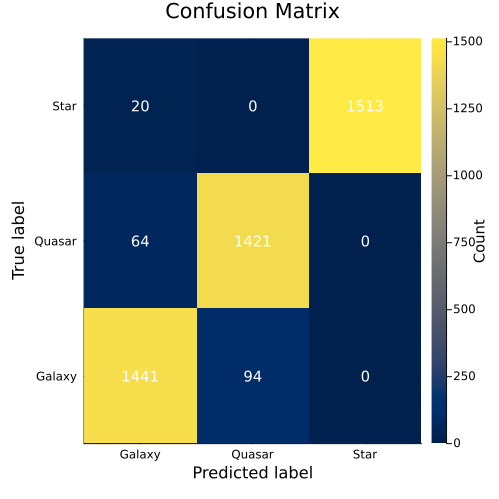

In [ ]:
""" Printing the confusion matrix """
p4 = Visualization.plot_confusion_heatmap(Ens_confusion)
display(p4)

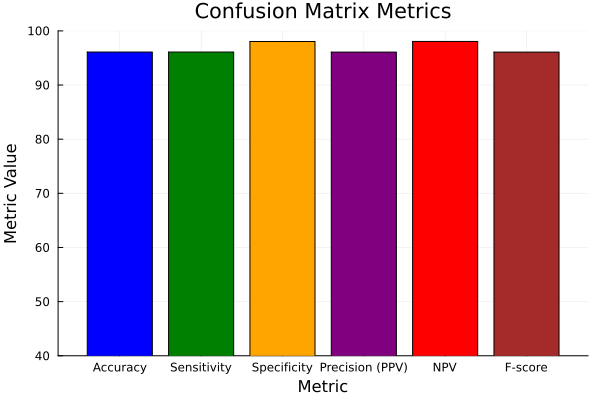

In [ ]:
Visualization.plot_confusion_metrics(Ens_acc, Ens_sensitivity, Ens_specificity, Ens_PPV, Ens_NPV, Ens_F_score)